In [37]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def exp_decay_sentiment(sentiment, days):
    weights = np.power(0.5, np.arange(days))
    return sum(sentiment.shift(i) * weight for i, weight in enumerate(weights))

In [12]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', header=0).Ticker.unique()
stock_data = pd.read_csv('data/SP500_stock_prices_log_clean_3monthreturn.csv', parse_dates=True)
date_sentiment = pd.read_csv('data/ATN_date_sentiment_max_dates.csv', parse_dates=True)
date_sentiment.rename(columns={'date':'Date'}, inplace=True)

In [14]:
# date column to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%Y-%m-%d')
date_sentiment['Date'] = pd.to_datetime(date_sentiment['Date'], format='%Y-%m-%d')

In [81]:
date_sentiment['exp_decay'] = exp_decay_sentiment(date_sentiment['sentiment'], 30)

<Axes: title={'center': 'Sentiment over time'}, xlabel='Date', ylabel='Sentiment'>

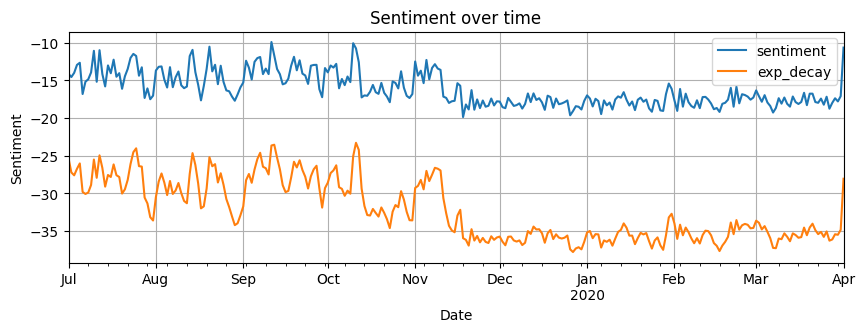

In [77]:
date_sentiment[date_sentiment.Date >= datetime(2019,7,1)].plot(x='Date', figsize=(10,3), title='Sentiment over time', ylabel='Sentiment', xlabel='Date', grid=True)

In [22]:
# combine stock data and sentiment data on the correct dates
# when sentiment has a date that stock data does not, discard the sentiment
stock_dates_sentiment = date_sentiment[date_sentiment.Date.isin(stock_data.Date)].copy()

In [24]:
# create cartesian product of stock data and sentiment data
unique_tickers = stock_data.Ticker.unique()
df_cartesian = pd.MultiIndex.from_product([unique_tickers, stock_dates_sentiment.Date], names=['Ticker', 'Date']).to_frame(index=False)

In [28]:
df_sentiment_long = pd.merge(df_cartesian, date_sentiment, on='Date', how='left')
df_joined = pd.merge(stock_data, df_sentiment_long, on=['Ticker', 'Date'], how='left')
stock_data_sentiment = df_joined.dropna(subset=['sentiment']).copy()

<Axes: title={'center': 'Sentiment over time'}, xlabel='Date', ylabel='Sentiment'>

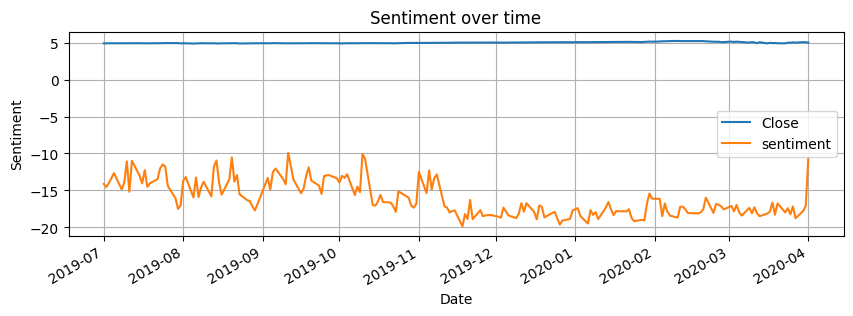

In [36]:
stock_data_sentiment[(stock_data_sentiment.Date >= datetime(2019,7,1)) & (stock_data_sentiment.Ticker == 'MSFT')][['Close', 'sentiment', 'Date']].plot(x='Date', figsize=(10,3), title='Sentiment over time', ylabel='Sentiment', xlabel='Date', grid=True)

<Axes: xlabel='Date'>

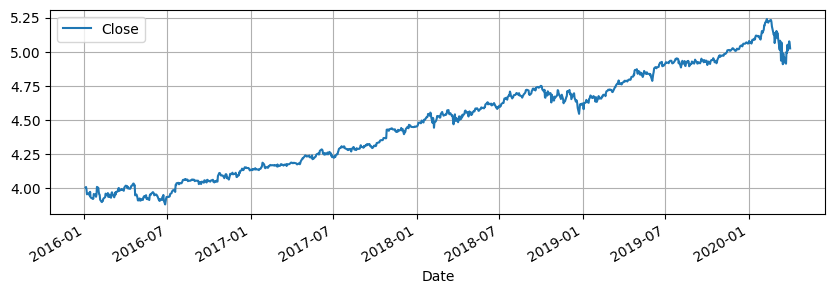

In [45]:
stock_data[stock_data.Ticker == 'MSFT'][['Close', 'Date']].plot(x='Date', figsize=(10,3), xlabel='Date', grid=True)

In [34]:
stock_data_sentiment[(stock_data_sentiment.Date >= datetime(2019,7,1)) & (stock_data_sentiment.Ticker == 'MSFT')]

,Date,Ticker,Open,Low,High,Close,Volume,Sector,log_return_3m,sentiment,exp_decay
324785,2019-07-01,MSFT,4.917276,4.905053,4.917789,4.910299,16.934057,Information Technology,0.131008,-14.123856,-25.350840
324786,2019-07-02,MSFT,4.913537,4.907790,4.916984,4.916911,16.539290,Information Technology,0.136192,-14.559125,-27.233808
324787,2019-07-03,MSFT,4.918520,4.914785,4.925368,4.923333,16.427732,Information Technology,0.136091,-14.000391,-27.616687
324788,2019-07-05,MSFT,4.912214,4.910594,4.922387,4.920419,16.713690,Information Technology,0.138275,-12.660747,-26.035113
324789,2019-07-08,MSFT,4.915592,4.908012,4.920711,4.919689,16.635681,Information Technology,0.133114,-14.857121,-29.901849
...,...,...,...,...,...,...,...,...,...,...,...
324971,2020-03-26,MSFT,4.999911,4.999709,5.054078,5.050561,17.983230,Information Technology,-0.008102,-17.173935,-35.071891
324972,2020-03-27,MSFT,5.022234,5.005288,5.042715,5.008633,17.859304,Information Technology,-0.058193,-18.764117,-36.298934
324973,2020-03-30,MSFT,5.026771,5.010702,5.078917,5.076610,17.965294,Information Technology,0.007958,-17.794489,-35.516467
324974,2020-03-31,MSFT,5.071417,5.053439,5.104611,5.060758,18.171286,Information Technology,0.000761,-17.095444,-34.852587


In [89]:
stock_data_sentiment.dropna(subset=['exp_decay']).drop(columns=['sentiment']).to_csv('data/SP500_stock_prices_log_clean_3monthreturn_sentiment.csv', index=False)

In [60]:
def DoubleAxisPlot(data, title, y_labels=[], columns=[], fig_kwargs={}, grid=False, max_return=False):

# double axis plot using closing price and volumne traded on second axis.
# Closing price in blue and volume in orange
# dates should be every 6 months

    if len(y_labels) == 1:
        y_labels = [y_labels]
    if len(columns) == 1:
        columns = [columns]

    fig, ax1 = plt.subplots(**fig_kwargs)

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(y_labels[0], color=color)
    ax1.plot(data.Date, data[columns[0]], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # show two vertical lines where one is the max 3 month return point, and the other is three months before that
    if max_return:
        max_3month_return_date = data[columns[0]].idxmax()
        ax1.axvline(x=max_3month_return_date, color='black', linestyle='--', alpha=0.2)
        ax1.axvline(x=max_3month_return_date + pd.Timedelta(days=-90), color='black', linestyle='--', alpha=0.2)

        ax1.axvspan(max_3month_return_date + pd.Timedelta(days=-90), 
                    max_3month_return_date, hatch='///',
                    color='green', alpha=0.1)

    if grid:
        # Make a grid that has vertical lines on every 3 months starting from the first date
        start_date = data[columns[0]].index[0]
        end_date = data[columns[0]].index[-1]
        date_range = pd.date_range(start_date - pd.Timedelta(days=3), end_date, freq='3MS')
        for date in date_range:
            ax1.axvline(x=date, color='black', linestyle='--', alpha=0.25)

    if columns[1] is not None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:orange'
        ax2.set_ylabel(y_labels[1], color=color)  # we already handled the x-label with ax1
        ax2.plot(data.Date, data[columns[1]], color=color, alpha=0.5)
        ax2.tick_params(axis='y', labelcolor=color)
    
    # plt.legend()
    fig.tight_layout()
    plt.title(title + f'\n {data.Ticker.iloc[0]}')
    plt.show()

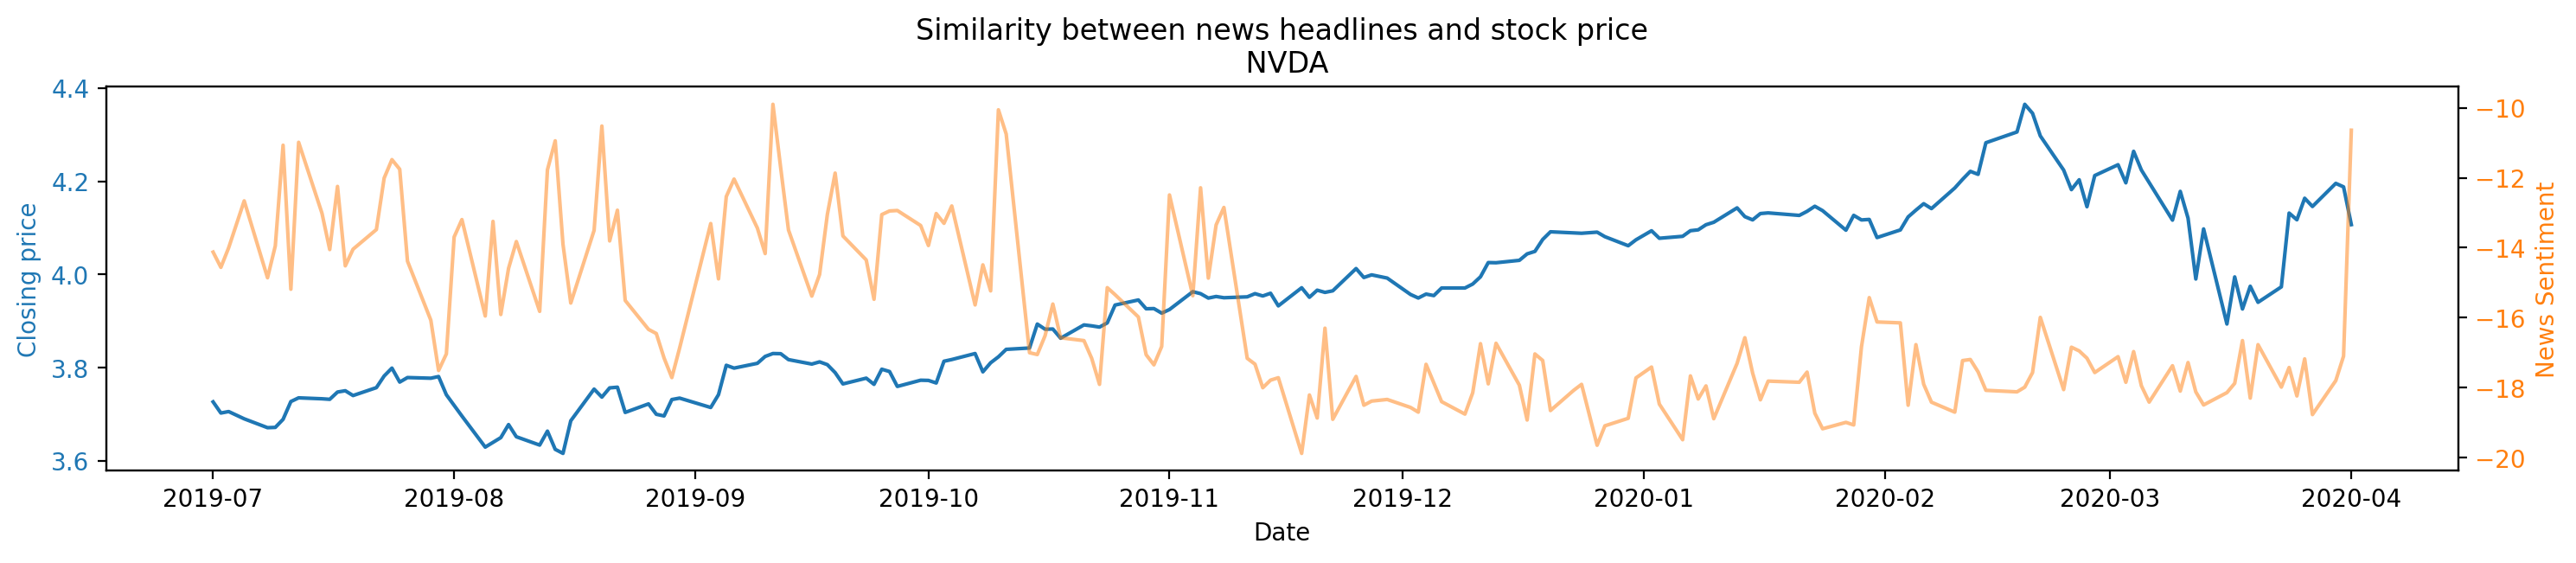

In [64]:
DoubleAxisPlot(stock_data_sentiment[(stock_data_sentiment.Date >= datetime(2019,7,1)) & (stock_data_sentiment.Ticker == 'NVDA')].copy(),
            'Similarity between news headlines and stock price',
            y_labels=['Closing price', 'News Sentiment'],
            columns = ['Close', 'sentiment'],
            fig_kwargs={'figsize': (15, 3), 'dpi': 200},
            grid=False,
            max_return=False,)

In [65]:
stock_data_sentiment

,Date,Ticker,Open,Low,High,Close,Volume,Sector,log_return_3m,sentiment,exp_decay
0,2016-01-04,MMM,4.997550,4.979488,4.999372,4.989207,15.002500,Industrials,0.024965,-14.188098,NaN
1,2016-01-05,MMM,4.989207,4.980932,4.993828,4.993557,14.804345,Industrials,0.007761,-15.355870,NaN
2,2016-01-06,MMM,4.980794,4.965777,4.981961,4.973210,14.913156,Industrials,-0.008957,-15.415397,NaN
3,2016-01-07,MMM,4.959482,4.946132,4.963753,4.948547,15.083444,Industrials,-0.045552,-17.338302,NaN
4,2016-01-08,MMM,4.951310,4.943212,4.959342,4.945137,14.795340,Industrials,-0.062026,-14.148434,NaN
...,...,...,...,...,...,...,...,...,...,...,...
516322,2020-03-26,ZTS,4.696016,4.696016,4.776515,4.769922,15.240786,Health Care,-0.119826,-17.173935,-35.071891
516323,2020-03-27,ZTS,4.740749,4.709890,4.768818,4.716443,14.869858,Health Care,-0.174131,-18.764117,-36.298934
516324,2020-03-30,ZTS,4.732947,4.722331,4.768564,4.759435,14.524482,Health Care,-0.132792,-17.794489,-35.516467
516325,2020-03-31,ZTS,4.750828,4.735321,4.789573,4.768054,15.190744,Health Care,-0.116338,-17.095444,-34.852587
